In [12]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.datasets import mnist
from keras.layers import Input, Dense, Conv2D, MaxPool2D, UpSampling2D
from keras.models import Model, load_model
from keras.utils import multi_gpu_model
from keras.callbacks import EarlyStopping,TensorBoard,ModelCheckpoint,ReduceLROnPlateau

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype(np.float32).reshape(-1,28,28,1) / 255
x_test = x_test.astype(np.float32).reshape(-1,28,28,1) / 255

In [3]:
x_train.shape,x_train.dtype

((60000, 28, 28, 1), dtype('float32'))

In [4]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0.,1.)
x_test_noisy = np.clip(x_test_noisy,0.,1.)

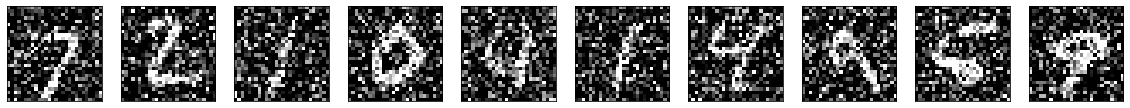

In [5]:
n=10
plt.figure(figsize=(20,2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [6]:
input_img = Input(shape=(28,28,1))
x = Conv2D(32, (3,3), padding='same', activation='relu')(input_img)
x = MaxPool2D((2,2), padding='same')(x)
x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
encoded = MaxPool2D((2,2),padding='same')(x)

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
x = Conv2D(32, (3,3), padding='same',activation='relu')(encoded)
x = UpSampling2D((2,2))(x)
x = Conv2D(32, (3,3), padding='same',activation='relu')(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2D(1, (3,3), padding='same', activation='sigmoid')(x)

In [8]:
autoencoder = Model(input_img, decoded)
parallel_model = multi_gpu_model(autoencoder,gpus=2)
parallel_model.compile(optimizer='adadelta', loss='binary_crossentropy')

In [13]:
callbacks = [
    # 当监测值不再改善时，该回调函数将中止训练
    # 如发现loss相比上一个epoch训练没有下降），则经过patience个epoch后停止训练。
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    # 该回调函数将日志信息写入TensorBorad
    TensorBoard(log_dir='./models/logs',histogram_freq=1),
    # 当评价指标不在提升时，减少学习率
    # min_lr：学习率的下限
    ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=3,min_lr=0.001),
    # 该回调函数将在每个epoch后保存模型到filepath
    ModelCheckpoint(filepath='models/weights-autoencoder-{epoch:02d}-{val_loss:.2f}.h5',save_best_only=True)
]

/home/mf/anaconda3/envs/py3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/mf/anaconda3/envs/py3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/mf/anaconda3/envs/py3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)


In [14]:
parallel_model.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=callbacks)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 5s 79us/step - loss: 0.0935 - val_loss: 0.0945
Epoch 2/100
60000/60000 [==============================] - 5s 78us/step - loss: 0.0935 - val_loss: 0.0934
Epoch 3/100
60000/60000 [==============================] - 5s 78us/step - loss: 0.0935 - val_loss: 0.0944
Epoch 4/100
60000/60000 [==============================] - 5s 78us/step - loss: 0.0936 - val_loss: 0.0935
Epoch 5/100
60000/60000 [==============================] - 5s 78us/step - loss: 0.0935 - val_loss: 0.0939
Epoch 6/100
60000/60000 [==============================] - 5s 79us/step - loss: 0.0930 - val_loss: 0.0931
Epoch 7/100
60000/60000 [==============================] - 5s 79us/step - loss: 0.0930 - val_loss: 0.0931
Epoch 8/100
60000/60000 [==============================] - 5s 78us/step - loss: 0.0930 - val_loss: 0.0931
Epoch 9/100
60000/60000 [==============================] - 5s 79us/step - loss: 0.0930 - val_loss: 0.0

In [19]:
autoencoder.save('models/autoencoder.h5')

In [20]:
autoencoder = load_model('models/autoencoder.h5')

In [17]:
decoded_imgs = autoencoder.predict(x_test_noisy)

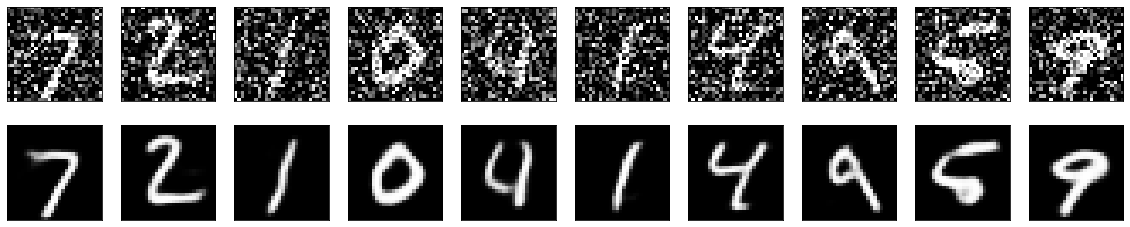

In [18]:
n = 10
plt.figure(figsize=(20,4))
for i in range(n):
    ax = plt.subplot(2,n,i+1)
    plt.imshow(x_test_noisy[i].reshape(28,28))
    plt.gray()
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()